# Predicción del rendimiento de CETES con el método de montecarlo

In [59]:
import pandas as pd

data = pd.read_csv('cetes_hist.csv')
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   date    2484 non-null   str  
 1   perc    2484 non-null   str  
dtypes: str(2)
memory usage: 38.9 KB


In [60]:
data['date'] = pd.to_datetime(data['date'], format='%d/%m/%Y')

def perc_to_yield(perc: str) -> float | None:
    try:
        return float(perc) / 100
    except ValueError:
        return None

data['yield'] = data['perc'].apply(lambda x: perc_to_yield(x))
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    2484 non-null   datetime64[us]
 1   perc    2484 non-null   str           
 2   yield   850 non-null    float64       
dtypes: datetime64[us](1), float64(1), str(1)
memory usage: 58.3 KB


In [61]:
data.dropna(inplace=True)
data.drop(columns=['perc'], inplace=True)
data.info()

<class 'pandas.DataFrame'>
Index: 850 entries, 642 to 2483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    850 non-null    datetime64[us]
 1   yield   850 non-null    float64       
dtypes: datetime64[us](1), float64(1)
memory usage: 19.9 KB


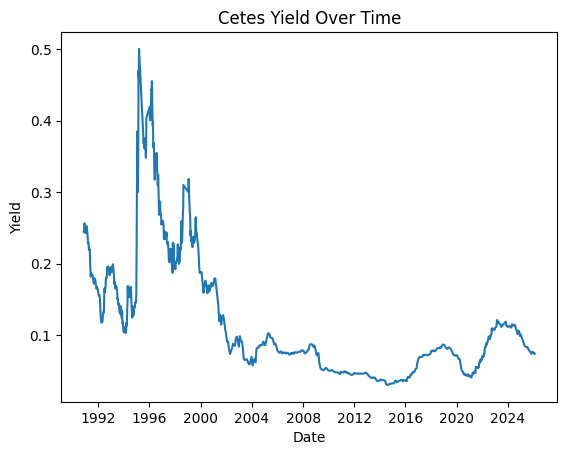

In [62]:
import matplotlib.pyplot as plt

plt.plot(data['date'], data['yield'])
plt.xlabel('Date')
plt.ylabel('Yield')
plt.title('Cetes Yield Over Time')
plt.show()

In [63]:
print(data['yield'].mean())
print(data['yield'].std())

0.14027364705882353
0.09319134165698105


In [64]:
data_xxi = data[data['date'] >= '2020-01-01']
print(data_xxi['yield'].mean())
print(data_xxi['yield'].std())

0.07865962441314554
0.026503893694895933


In [65]:
import numpy as np
from sklearn.linear_model import LinearRegression

def estimar_vasicek(tasas: np.ndarray, dt=1/12):
    """
    Estima kappa, theta y sigma usando regresión lineal.
    tasas: Array de tasas históricas (ej. [0.05, 0.051, ...])
    dt: Paso de tiempo (1/12 para datos mensuales, 1/252 para diarios)
    """
    X = tasas[:-1].reshape(-1, 1) # r_t
    y = tasas[1:]                 # r_{t+1}

    modelo = LinearRegression()
    modelo.fit(X, y)
    
    m = modelo.coef_[0]
    c = modelo.intercept_
    
    kappa = (1 - m) / dt
    theta = c / (1 - m)
    
    return kappa, theta

tasas = data_xxi['yield'].values
kappa, theta = estimar_vasicek(tasas)
print(f"Estimación Vasicek: kappa={kappa:.4f}, theta={theta:.4f}")

Estimación Vasicek: kappa=0.0320, theta=0.0820


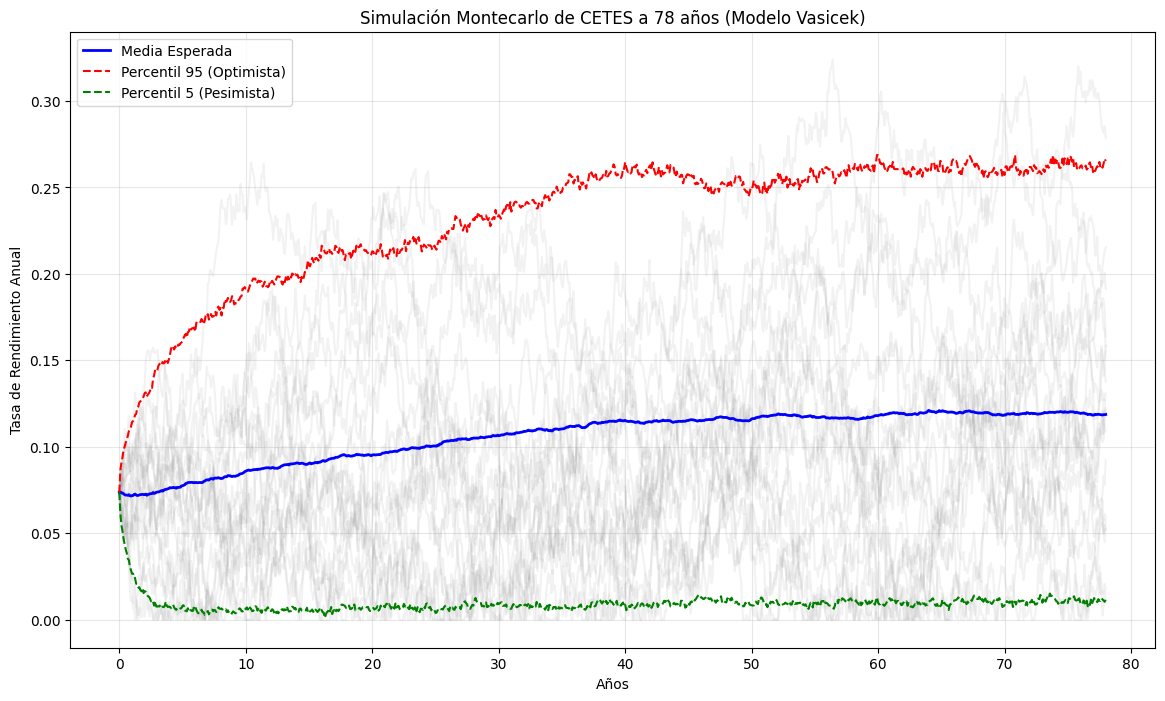

In [66]:
r0 = data_xxi['yield'].iloc[-1]
theta = data_xxi['yield'].mean()
sigma = data_xxi['yield'].std()
T = 78
dt = 1/12
N = int(T / dt)
M = 1000

rates = np.zeros((N + 1, M))
rates[0] = r0

# 3. Simulación Montecarlo (Método de Euler-Maruyama)
np.random.seed(3) # Para reproducibilidad
for t in range(1, N + 1):
    dr = kappa * (theta - rates[t-1]) * dt + sigma * np.sqrt(dt) * np.random.normal(0, 1, M)
    rates[t] = rates[t-1] + dr
    
    # Opcional: Asegurar que las tasas no sean negativas (aunque Vasicek permite negativas teóricamente)
    rates[t] = np.maximum(rates[t], 0.0) 

# 4. Análisis de Resultados
time_axis = np.linspace(0, T, N + 1)
mean_path = np.mean(rates, axis=1)
percentile_5 = np.percentile(rates, 5, axis=1)
percentile_95 = np.percentile(rates, 95, axis=1)

# Gráfica
plt.figure(figsize=(14, 8))
plt.plot(time_axis, rates[:, :20], alpha=0.1, color='gray') # Mostrar solo 20 caminos de fondo
plt.plot(time_axis, mean_path, color='blue', linewidth=2, label='Media Esperada')
plt.plot(time_axis, percentile_95, color='red', linestyle='--', label='Percentil 95 (Optimista)')
plt.plot(time_axis, percentile_5, color='green', linestyle='--', label='Percentil 5 (Pesimista)')

plt.title(f'Simulación Montecarlo de CETES a {T} años (Modelo Vasicek)')
plt.xlabel('Años')
plt.ylabel('Tasa de Rendimiento Anual')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

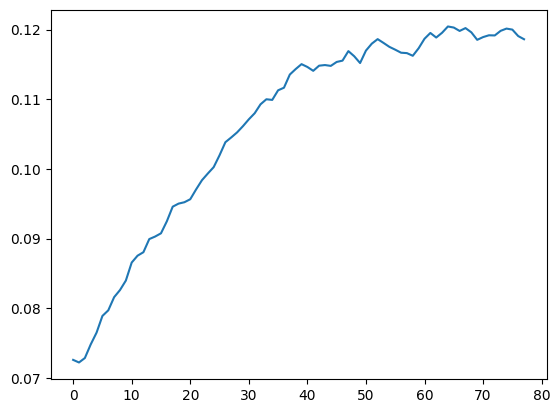

In [67]:
mean_path = mean_path[:len(mean_path) - len(mean_path)%12]
pred = mean_path.reshape(-1, 12)

final_pred = np.zeros(len(pred))
for i, p in enumerate(pred):
    final_pred[i] = p.mean()

plt.plot(final_pred)
plt.show()

In [68]:
cetes_pred = {'year': [], 'predicted_yield': []}

current_year = 2026
for i in range(78):
    cetes_pred['year'].append(current_year + i)
    cetes_pred['predicted_yield'].append(final_pred[i])

cetes_pred_df = pd.DataFrame(cetes_pred)
cetes_pred_df

,year,predicted_yield
0,2026,0.072584
1,2027,0.072210
2,2028,0.072848
3,2029,0.074800
4,2030,0.076496
...,...,...
73,2099,0.119808
74,2100,0.120130
75,2101,0.119985
76,2102,0.119058


In [69]:
cetes_pred_df.to_csv('cetes_pred.csv', index=False)